In [1]:
%run ./const
%run ./param
import sys
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm
import scipy.optimize as opt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-0.5
muH         = 1/0.75
###########################

const = Const()
pm = Param("Inputs", const).paramDict

In [2]:
class EvolveControl:
    def __init__(self, const, pm):
        self.r_start = pm['R_START']
        self.r_delta = pm['R_DELTA']
        self.r_steps = pm['R_STEPS']
        self.sonic_point = pm['SONIC_POINT']
        self.r_wind = self.r_start
        self.r_cloud = self.r_start

In [3]:
class Cooling:
    def __init__(self, fname):
        file = glob.glob(fname) ## CHANGE FOR WHERE YOU WANT TO KEEP IT
        if len(file) > 0:
            data = np.load(file[0])
            Lambda_tab = data['Lambda_tab']
            redshifts  = data['redshifts']
            Zs         = data['Zs']
            log_Tbins  = data['log_Tbins']
            log_nHbins = data['log_nHbins']    
            self.Lambda     = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=1e-30)
        else:
            print("Cooling curve file not found")
            
    def tcool_P(self, T,P, metallicity, mu, muH):
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        return 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))

In [4]:
coolCurve = Cooling('Lambda_tab_redshifts.npz')
coolCurve.Lambda((-1, np.log10(1e6), 0.02, 0))

array(9.08173569e-24)

In [5]:
class Wind:      
    
    def __init__(self, control, const, pm, res):
        r0 = control.sonic_point   # sonic point
        r_start = control.r_start
        self.gamma = 5/3     # adiabatic index
        epsilon = 1e-5   
        Mach0 = 1       
        Mach = Mach0 * (1+epsilon)        
        beta = pm['BETA']      # mass loading 
        alpha = pm['ALPHA']     # energy loading
        SFR = pm['SFR']       # star formation rate
        Mdot = pm['MDOT']        # mass injection rate
        Edot = pm['EDOT']    # energy injection rate
        v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach**2)))**(-1/2)  # velocity at sonic point
        rho0 = Mdot / (4 * np.pi * r0**2 * v0)   # density at sonic point
        P0 = rho0 * (gamma - 1)/gamma * (Edot/Mdot - v0**2/2)   # pressure at sonic point
        self.v0 = v0
        self.P0 = P0
        self.rho0 = rho0
        Vol = 4/3 * np.pi * r0**3         
        self.Mdot_per_Vol = Mdot / Vol    
        self.Edot_per_Vol = Edot / Vol
        self.v_c = 0    
        self.P = P0
        self.v = v0
        self.rho = rho0
        self.T = self.P / kb * (mu * mp / self.rho)
        
        def supersonic(r,z):
            return z[0]/np.sqrt(gamma*z[2]/z[1]) - 1.001

        supersonic.terminal = True
        supersonic.direction = -1        
        
        def evolve(r, z):
            v,rho,P = z
            (dv_dr, drho_dr, dP_dr) = self.getDerivatives(r, v, rho, P, r0, 0, 0, 0)    
            return [dv_dr, drho_dr, dP_dr] 

        # transverse the wind to starting position
        if r_start > r0:
            self.sol_sup = solve_ivp(evolve, [r0, r_start], 
                            [self.v,self.rho,self.P], dense_output=True, 
                            rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb])                

            dv_dr, drho_dr, dP_dr = self.getDerivatives(r0, v0, rho0, P0, r0, 0, 0, 0)
            dlogvdlogr = dv_dr * r0/v0
            dlogrhodlogr = drho_dr * r0/rho0
            dlogPdlogr = dP_dr * r0/P0

            dlogr0 = -1e-8

            v0_sub = 10**(np.log10(v0) + dlogvdlogr * dlogr0)
            rho0_sub = 10**(np.log10(rho0) + dlogrhodlogr * dlogr0)
            P0_sub = 10**(np.log10(P0) + dlogPdlogr * dlogr0)
            
            self.sol_sub = solve_ivp(evolve, [10**(np.log10(r0)+dlogr0), 10**-1.2*r0], [v0_sub,rho0_sub, P0_sub],
                events=supersonic, dense_output=True, rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb])            
            
        res.add_wind_r(np.append(self.sol_sub.t[::-1], self.sol_sup.t))
        res.add_wind_v(np.append(self.sol_sub.y[0][::-1],self.sol_sup.y[0]))
        res.add_wind_rho(np.append(self.sol_sub.y[1][::-1], self.sol_sup.y[1]))
        res.add_wind_P(np.append(self.sol_sub.y[2][::-1], self.sol_sup.y[2]))
        self.r = res.wind_r[-1]
        self.v = res.wind_v[-1]
        self.P = res.wind_P[-1]
        self.rho = res.wind_rho[-1]
        self.T = self.P / kb * (mu * mp / self.rho)        
        
        
    def getDerivatives(self, r, v, rho, P, r_sonic, rho_dot, p_dot, epsilon_dot):
        gamma = self.gamma
        r0 = r_sonic
        Mdot_per_Vol = self.Mdot_per_Vol
        Edot_per_Vol = self.Edot_per_Vol

        if pm['BACK_REACTION'] == 0:
            rho_dot = 0
            p_dot = 0
            epsilon_dot = 0
        
        c_s_sqr = gamma * P / rho
        v_c_sqr = 0
        v_esc = 0
        
        
#        Srho = np.where(r<r0, Mdot_per_Vol, rho_dot)
#        Sv = np.where(r<r0, (- v * Mdot_per_Vol) / rho, (p_dot - v * rho_dot) / rho ) #no momentum flux
#        Se = np.where(r<r0, (Edot_per_Vol + v**2 * Mdot_per_Vol - (v**2/2 + c_s_sqr / (gamma-1)) * Mdot_per_Vol)/rho, \
#                            (epsilon_dot - p_dot * v + v**2 * rho_dot - (v**2/2 + c_s_sqr / (gamma-1)) * rho_dot)/rho) # no cooling and v_esc
        

        rho_dot = np.where(r<r0, Mdot_per_Vol, rho_dot)
        p_dot = np.where(r<r0, 0, p_dot)
        epsilon_dot = np.where(r<r0, Edot_per_Vol, epsilon_dot)
        
        Srho = rho_dot
        Sv = (p_dot - v * rho_dot) / rho
        vB2 = 0.5 * v**2 + c_s_sqr / (gamma-1) -0.5 * v_esc**2
        Se = (epsilon_dot - (p_dot - v * rho_dot) * v - rho_dot*vB2)/rho 
        
        dv_dr = (v/r * (2*c_s_sqr - v_c_sqr) - c_s_sqr*Srho/rho + v*Sv - (gamma-1)*Se) / (v**2-c_s_sqr)
        drho_dr = (rho/r*(v_c_sqr-2*v**2) + v*Srho - rho*Sv + (gamma-1)*rho/v*Se) / (v**2-c_s_sqr)
        dP_dr = (gamma*P/r*(v_c_sqr-2*v**2) + c_s_sqr*v*Srho - gamma*P*Sv + (gamma-1)*rho*v*Se) / (v**2-c_s_sqr)

        return (dv_dr, drho_dr, dP_dr)
    

    def step(self, cloud):
        
        dr = control.r_delta
        r_sonic = control.sonic_point
        rho_dot = cloud.wind_rho_dot
        p_dot = cloud.wind_p_dot
        epsilon_dot = cloud.wind_epsilon_dot
        
        def evolve(r, z):
            v,rho,P = z
            (dv_dr, drho_dr, dP_dr) = self.getDerivatives(r, v, rho, P, r_sonic, rho_dot, p_dot, epsilon_dot)    
            return [dv_dr, drho_dr, dP_dr]        

        sol_sup = solve_ivp(evolve, [self.r, self.r+dr], 
                            [self.v,self.rho,self.P], dense_output=True, 
                            rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb])
        self.v = sol_sup.y[0][-1]
        self.rho = sol_sup.y[1][-1]
        self.P = sol_sup.y[2][-1]
        self.T = self.P / kb * (mu * mp / self.rho)
        self.r += dr
        res.add_wind_r(self.r)
        res.add_wind_v(self.v)
        res.add_wind_rho(self.rho)
        res.add_wind_P(self.P)


In [6]:
class Cloud:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']
    metallicity = pm['METALLICITY']    
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    t_cool_layer = 1  * Myr

    mu          = 0.62
#    metallicity = 10**-0.5
    muH         = 1/0.75
    
    cool = Cooling(pm['COOL_FILE'])
    Lambda = cool.Lambda
    
    
    def __init__(self, wind, control, const, pm, res):
         
        self.r = control.r_start    
        # not exactly lognormal but can generate approximate lognormal
        # with its log10(x) having specificed mean and sigma in log space
        def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            logbins = np.arange(bmin,bmax,bin_size)
            bins = 10**logbins * unit
            mu = mu + np.log10(unit)
            z=(np.log10(bins[1:-1])-mu)/sigma
            f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f 

        def lognormal(bmin, bmax, nbs_bins, mu, sigma, unit):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            logbins = np.arange(bmin,bmax,bin_size)
            bins = 10**logbins * unit
            mu = mu + np.log10(unit)
            z=(np.log10(bins[1:-1])-mu)/sigma
            f = np.log10(np.e) / (bins[1:-1] * sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f         
        
        def normal(bmin, bmax, nbs_bins, mu, sigma, unit):
            bin_size = (bmax-bmin)/(nbs_bins+2)
            bins = np.arange(bmin,bmax,bin_size) *unit
            z = (bins[1:-1]/unit - mu)/(sigma)
            f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
            _delta = bins[1:]-bins[:-1]
            delta_b = _delta[:-1]
            delta_f = _delta[1:]
            return f, bins[1:-1], delta_b, delta_f    

        (self.mf,self.mbin,self.dm_b, self.dm_f) =lognormal(self.M_min, 
                                                            self.M_max, 
                                                            self.ncells_M, 
                                                            self.M_mu, 
                                                            self.M_sigma,
                                                            Msun)
        (self.vf,self.vbin,self.dv_b, self.dv_f)=normal(self.v_min, 
                                                         self.v_max, 
                                                         self.ncells_v, 
                                                         self.v_mu,
                                                         self.v_sigma,
                                                         km) 
        self.indices = [(i,j) for j in range(self.ncells_v) for i in range(self.ncells_M)]        
        # scale to match the total mass input
#        m_factor = sum(self.mf * self.mbin * (self.dm_f + self.dm_b)/2)
        self.integrateDelta = np.tile((self.dm_b + self.dm_f) * 0.5, self.ncells_v) * \
                              np.repeat((self.dv_b + self.dv_f) * 0.5, self.ncells_M)
        self.f=np.array([self.mf[item[0]]*self.vf[item[1]] for item in self.indices])
        (_,_,_,_,rho_dot,_,_) = self.dot_cloud(wind.P, wind.v, wind.rho, self.r)
        dot_rho_target_per_vol = self.rho_source_target / (4/3*np.pi*self.r**3)
        m_factor = dot_rho_target_per_vol / sum(rho_dot * self.integrateDelta)    # target number density
        self.f *= np.where(m_factor < 0, -m_factor, m_factor)
        res.add_cloud_r(self.r)
        res.add_cloud_f(self.f)
        
                        
 
    def integrateMass(self):
        integrand = self.f * self.r**2 * 4 * np.pi * np.tile(self.mbin, self.ncells_v)
        return sum(integrand * self.integrateDelta)
    
    def integrateNFlux(self):
        integrand = self.f * np.repeat(self.vbin, self.ncells_M) * self.r**2 * 4 * np.pi 
        return sum(integrand * self.integrateDelta)

    def integrateN(self):
        integrand = self.f * self.r**2 * 4 * np.pi 
        return sum(integrand * self.integrateDelta)
    
    
     

        
    def dot_cloud(self, P, v, rho, r):
        M_cloud = np.tile(self.mbin, self.ncells_v)
        v_cloud = np.repeat(self.vbin, self.ncells_M)
        n_cloud = self.f
        Lambda_cool = lambda T : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.)        
        # cloud_radius(M_cloud,v_cloud):
        T_cloud   = self.T_cloud
        rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
        chi         = rho_cloud / rho
        r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
        # layer_turbulent_velocity(M_cloud,v_cloud):
        
        v_turb0      = self.f_turb0*(v-v_cloud)
        v_turb = np.where(v_turb0 <=0, 0.001, v_turb0)
                
        T_wind  = P/kb * (mu*mp/rho)
        T_mix   = np.sqrt(T_wind*T_cloud)

        # layer_cooling_time
        T = T_mix
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/kb/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * Lambda_cool(T_mix))        

#        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))        
#        t_cool_layer = self.cool.tcool_P(T_mix, P/kb, self.metallicity, self.mu, self.muH)    
#        t_cool_layer = self.t_cool_layer    
        


        # cloud_ksi(M_cloud,v_cloud):        
        ksi     = r_cloud / (v_turb * t_cool_layer)

        # Mdot_cloud_grow(M_cloud,v_cloud):
        Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**self.Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**self.Mdot_chi_power) 
        force_from_transfer = (v-v_cloud)*Mdot_grow
        Mdot_over_v = (Mdot_grow + Mdot_loss)/v_cloud
        vdot_over_v = (force_from_transfer/M_cloud)/v_cloud 
#        Ndot = N_cloud * v_cloud
#        n_cloud = Ndot / (4 * np.pi * r**2 * v_cloud)
#        rhodot = (Mdot_grow + Mdot_loss) * n_cloud
        rhodot = (Mdot_grow + Mdot_loss) * n_cloud
        pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + self.gamma / (self.gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * v_cloud**2 + self.gamma / (self.gamma - 1) * P / rho_cloud
        epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud
        return M_cloud, v_cloud, Mdot_over_v, vdot_over_v, rhodot, pdot, epsilondot   
        


    def upwind(self, dot, dr):
        (m_cl, v_cl, mdot, vdot, _, _, _) = dot
        dm_f = np.tile(self.dm_f, cloud.ncells_v)
        dm_b = np.tile(self.dm_b, cloud.ncells_v)
        dv_f = np.repeat(self.dv_f, cloud.ncells_M)
        dv_b = np.repeat(self.dv_b, cloud.ncells_M)
        M_pos_band = np.where(mdot>0, 0, mdot/dm_f) * dr
        M_neg_band = np.where(mdot>0, mdot/dm_b, 0) * dr
        v_pos_band = np.where(vdot>0, 0, vdot/dv_f) * dr
        v_neg_band = np.where(vdot>0, vdot/dv_b, 0) * dr

        # zero out location to avoid wrapping around 
        M_neg_band = np.array([np.where(i%self.ncells_M==0, 0, M_neg_band[i]) for i in range(len(M_neg_band))]) 
        M_pos_band = np.concatenate([[0],M_pos_band])
        M_pos_band = np.array([np.where(i%self.ncells_M==0, 0, M_pos_band[i]) for i in range(len(M_pos_band))]) 
        M_pos_band = M_pos_band[1:]

        diagonal = 1 + v_neg_band - v_pos_band - M_pos_band + M_neg_band    
        v_pos_band = v_pos_band[:-self.ncells_M]
        M_pos_band = M_pos_band[:-1]
        M_neg_band = -M_neg_band[1:]
        v_neg_band = -v_neg_band[self.ncells_M:]
        return diags([v_pos_band, M_pos_band, diagonal, M_neg_band, v_neg_band],[self.ncells_M, 1, 0,-1,-self.ncells_M])     

    def step(self, wind):
        dr = control.r_delta
        P_wind = wind.P
        if P_wind < 0:
            sys.exit('Negative Pressure')
        v_wind = wind.v
        rho_wind = wind.rho
        if rho_wind < 0:
            sys.exit('Negative Mass Density')
        dot = self.dot_cloud(P_wind, v_wind, rho_wind, self.r) 
        (_, _, _, _, rho_dot, p_dot, epsilon_dot) = dot
        self.wind_rho_dot = -sum(rho_dot * self.integrateDelta)
        self.wind_p_dot = -sum(p_dot * self.integrateDelta)
        self.wind_epsilon_dot = -sum(epsilon_dot * self.integrateDelta)
        upwind_mtrx = self.upwind(dot, dr)
        self.f = spsolve(upwind_mtrx,self.f)
        self.r += dr    
        res.add_cloud_f(self.f)
        res.add_cloud_r(self.r)
    
        

In [7]:
class Result:
    def __init__(self):
        self.wind_r = []
        self.cloud_r = []
        self.wind_v = []
        self.wind_rho = []
        self.wind_P = []
        self.cloud_f = []
            
    def add_wind_r(self, r):
        self.wind_r = np.append(self.wind_r, r)

    def add_cloud_r(self, r): 
        self.cloud_r = np.append(self.cloud_r, r)
            
    def add_wind_v(self, v):
        self.wind_v = np.append(self.wind_v, v)
        
    def add_wind_rho(self, rho):
        self.wind_rho = np.append(self.wind_rho, rho)

    def add_wind_P(self, P):
        self.wind_P = np.append(self.wind_P, P)

    def add_cloud_f(self, f):
        self.cloud_f.append(f)

    def plot_wind(self, pm):
        R=pm['SONIC_POINT']
        r=self.wind_r
        u_star = self.wind_v/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
        rho_star = self.wind_rho/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
        P_star = self.wind_P/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
        plt.figure(figsize=(6,6))
        plt.plot(np.log(r/R),np.log(u_star), label='Nomalized velocity')
        plt.plot(np.log(r/R),np.log(rho_star), label = 'Normalized density')
        plt.plot(np.log(r/R),np.log(P_star), label = 'Normalized pressure')
        plt.legend()
        plt.title('Numerical Solutions for Hot Wind')
        
    def plot_cloud(self, i, cloud, const):
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))

        plt.figure(figsize=(6,6))
        plt.pcolormesh(np.log10(cloud.mbin/const.Msun),cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))
        
        
    def plot_mass(self, i, cloud, const):
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
        m = phase.sum(axis=0)
        plt.figure(figsize=(6,6))
        plt.plot(np.log10(cloud.mbin/const.Msun), m/max(m))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
        
        
    def plot_velocity(self, i, cloud, const):
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))           
        v= phase.sum(axis =1)
        plt.figure(figsize=(6,6))
        plt.plot(cloud.vbin/km, v/max(v))
        plt.xlabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.ylabel(r'Normalized Number Density')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
20
40
60


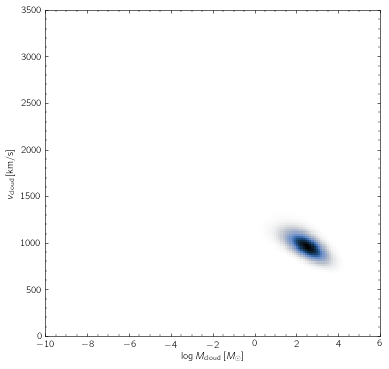

In [8]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)


res = Result()
wind = Wind(control, const, pm, res)
cloud = Cloud(wind, control, const, pm, res)


nflux = []
mass = []
N = []


steps= control.r_steps

for i_time in range(steps):
    cloud.step(wind)
    nflux.append(cloud.integrateNFlux())
    mass.append(cloud.integrateMass())
    N.append(cloud.integrateN())
    wind.step(cloud)    
    if i_time % 20 == 0:
        print(i_time)
#    print(i_time)
        
res.plot_cloud(steps-1, cloud, const)

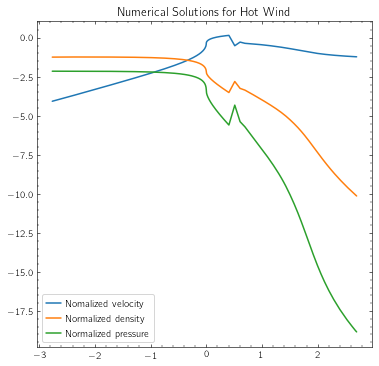

In [9]:
res.plot_wind(pm)

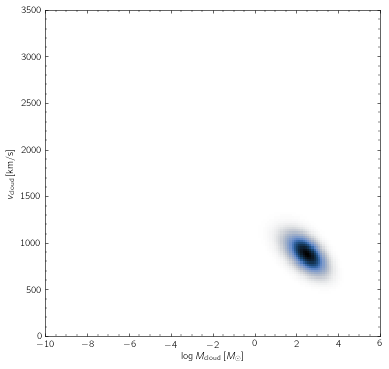

In [10]:
res.plot_cloud(10, cloud, const)

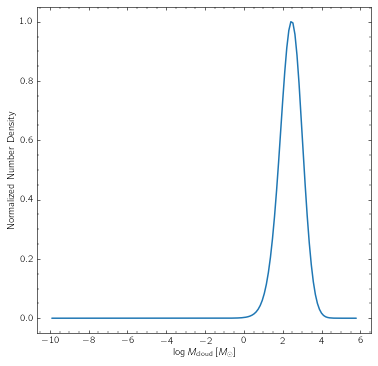

In [11]:
res.plot_mass(10, cloud, const)

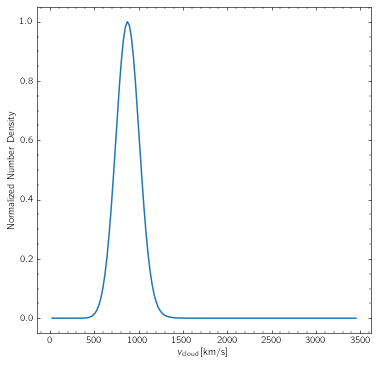

In [12]:
res.plot_velocity(10, cloud, const)
